# Flatten domain-IP JSON to a tidy DataFrame

This notebook streams a large **JSON-Lines** export (one JSON object per line),
explodes the `ip_data` list so you get **one row per IP**, flattens nested
structures with `pandas.json_normalize`, converts Mongo `$date` strings to
`datetime64[ns, UTC]`, and finally writes an efficient Parquet file.

Place your raw file next to this notebook and name it **`domains.json`**.  
If your file lives elsewhere, just change the `path` variable in the first code cell.


In [ ]:
import json, pandas as pd, random
from pathlib import Path

# --- 1)  stream the massive JSON-lines export ------------------
# Construct the path to the JSON file relative to this script's location.
script_path = Path.cwd()
# Go up 3 levels to the project root (from transformers/data -> transformers -> project_root)
project_root = script_path.parent.parent

def stream_json(path: Path):
    """Yield one parsed JSON object per line (memory-friendly)."""
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield json.loads(line)

malware_file_path = project_root / "datasets" / "malware" / "malware_strict_ip_2024.json"
benign_file_path = project_root / "datasets" / "benign" / "benign_strict_ip_2024.json"
records = list(stream_json(malware_file_path))  # for truly huge files, build chunks
print(f"Loaded {len(records):,} domain objects")


Loaded 100,809 domain objects


In [ ]:
# --- 2)  explode `ip_data` and flatten everything else ----------
df = pd.json_normalize(
        records,
        record_path="ip_data",                # → 1 row per IP
        meta=["domain_name", ["_id", "$oid"]],
        sep="."                               # dotted column names
     ).rename(columns={"_id.$oid": "domain_id"})

print("Shape:", df.shape)
df.head()



Shape: (160536, 60)


,ip,from_record,remarks.rdap_evaluated_on.$date,remarks.asn_evaluated_on.$date,remarks.geo_evaluated_on.$date,remarks.icmp_evaluated_on,remarks.is_alive,remarks.average_rtt,rdap.handle,rdap.parent_handle,...,remarks.icmp_evaluated_on.$date,rdap.entities.routing,rdap.entities.dns,rdap.registration_date,asn,rdap.last_changed_date,geo,rdap.entities.registrar,domain_name,domain_id
0,192.243.61.225,A,2023-11-28T16:14:57.354Z,2023-11-28T16:14:57.354Z,2023-11-29T12:44:26.883Z,NaN,False,0.000,NET-192-243-48-0-1,NET-192-0-0-0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,irradiateher.com,6565e3c49a18c76b58687467
1,173.233.137.44,A,2023-11-28T16:15:06.142Z,2023-11-28T16:15:06.142Z,2023-11-29T12:44:26.884Z,NaN,False,124.545,NET-173-233-136-0-1,NET-173-233-128-0-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,irradiateher.com,6565e3c49a18c76b58687467
2,192.243.59.12,A,2023-11-28T16:15:17.609Z,2023-11-28T16:15:17.609Z,2023-11-29T12:44:26.884Z,NaN,False,104.985,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,irradiateher.com,6565e3c49a18c76b58687467
3,192.243.59.13,A,2023-11-28T16:15:18.148Z,2023-11-28T16:15:18.149Z,2023-11-29T12:44:26.884Z,NaN,False,112.451,NET-192-243-59-0-1,NET-192-243-48-0-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,irradiateher.com,6565e3c49a18c76b58687467
4,192.243.61.227,A,2023-11-28T16:15:27.06Z,2023-11-28T16:15:27.06Z,2023-11-29T12:44:26.884Z,NaN,False,107.473,NET-192-243-48-0-1,NET-192-0-0-0-0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,irradiateher.com,6565e3c49a18c76b58687467


In [1]:
import pandas as pd
from pathlib import Path
import json
import random

In [6]:
# Change 'domains.json' to your file if different

def stream_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield json.loads(line)

df = pd.DataFrame(stream_json(malware_file_path))
print(df.shape, "domain rows loaded")


(100809, 3) domain rows loaded


In [19]:
def geo_tokens_from_ip_data(ip_data):
    """
    Return a list of token strings built from ip_data's geo sub-objects.
    Uses FULL country names; handles missing/None values safely.
    """
    if not ip_data:
        return [
            "ip_count: 0",
            "countries: NA",
            "regions: NA",
            "cities: NA",
            "timezones: NA",
        ]

    ip_count = len(ip_data)
    countries, regions, cities, timezones = set(), set(), set(), set()

    for rec in ip_data:
        if not isinstance(rec, dict):
            continue
        geo = rec.get("geo") or {}
        countries.add(geo.get("country") or geo.get("country_code") or "NA")
        regions.add(geo.get("region") or "NA")
        cities.add(geo.get("city") or "NA")
        timezones.add(geo.get("timezone") or "NA")

    def uniq(vals):
        vals.discard("NA")
        return ", ".join(sorted(vals)) if vals else "NA"

    return [
        f"ip_count: {ip_count}",
        f"countries: {uniq(countries)}",
        f"regions:   {uniq(regions)}",
        f"cities:    {uniq(cities)}",
        f"timezones: {uniq(timezones)}",
    ]


In [20]:
def prepare_geo_input_string(row):
    CLS, SEP = "[CLS]", "[SEP]"
    tokens = []

    # domain token
    domain = (row.get("domain_name") or "NA").lower().lstrip("www.")
    tokens.append(f"domain: {domain}")

    # geo tokens
    tokens.extend(geo_tokens_from_ip_data(row.get("ip_data")))

    return f"{CLS} " + f" {SEP} ".join(tokens) + f" {SEP}"

df["input_string"] = df.apply(prepare_geo_input_string, axis=1)
df[["domain_name", "input_string"]].head()


,domain_name,input_string
0,irradiateher.com,[CLS] domain: irradiateher.com [SEP] ip_count:...
1,eloquentcs.com,[CLS] domain: eloquentcs.com [SEP] ip_count: 1...
2,www.neutralsystemsolution.space,[CLS] domain: neutralsystemsolution.space [SEP...
3,www.drshiwanijainpainclinic.com,[CLS] domain: drshiwanijainpainclinic.com [SEP...
4,mkt9136.com,[CLS] domain: mkt9136.com [SEP] ip_count: 1 [S...


In [15]:
df["input_string"] = df.apply(prepare_geo_input_string, axis=1)
df[["domain_name", "input_string"]].head()

,domain_name,input_string
0,irradiateher.com,[CLS] ip_count: 10 [SEP] countries: United Sta...
1,eloquentcs.com,[CLS] ip_count: 1 [SEP] countries: United Stat...
2,www.neutralsystemsolution.space,[CLS] ip_count: 1 [SEP] countries: United Stat...
3,www.drshiwanijainpainclinic.com,[CLS] ip_count: 1 [SEP] countries: The Netherl...
4,mkt9136.com,[CLS] ip_count: 1 [SEP] countries: Germany [SE...


In [16]:
# --- Tokenise ----------------------------------------------------
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

encodings = tokenizer(
    df["input_string"].tolist(),
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt"
)

# --- Inspect a few examples -------------------------------------
def show_tokens(example_idx=0):
    """
    Print the original input_string, its token list, and token ids
    for a single row (default: first row).
    """
    print("DOMAIN:", df.iloc[example_idx]["domain_name"])
    print("\nInput string:")
    print(df.iloc[example_idx]["input_string"])
    print("\nTokens:")
    tokens = tokenizer.convert_ids_to_tokens(
        encodings["input_ids"][example_idx]
    )
    print(tokens)
    print("\nToken IDs:")
    print(encodings["input_ids"][example_idx].tolist())
    print("\nAttention mask:")
    print(encodings["attention_mask"][example_idx].tolist())

# Display the first three examples
for idx in range(3):
    print("="*60)
    show_tokens(idx)


DOMAIN: irradiateher.com

Input string:
[CLS] ip_count: 10 [SEP] countries: United States [SEP] regions: Virginia [SEP] cities: Ashburn [SEP] timezones: America/Chicago, America/New_York [SEP]

Tokens:
['[CLS]', '[CLS]', 'ip', '_', 'count', ':', '10', '[SEP]', 'countries', ':', 'united', 'states', '[SEP]', 'regions', ':', 'virginia', '[SEP]', 'cities', ':', 'ash', '##burn', '[SEP]', 'time', '##zone', '##s', ':', 'america', '/', 'chicago', ',', 'america', '/', 'new', '_', 'york', '[SEP]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Token IDs:
[101, 101, 12997, 1035, 4175, 1024, 2184, 102, 3032, 1024, 2142, 2163, 102, 4655, 1024, 3448, 102, 3655, 1024, 6683, 8022, 102, 2051, 15975, 2015, 1024, 2637, 1013, 3190, 1010, 2637, 1013, 2047, 1035, 2259, 102, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0,

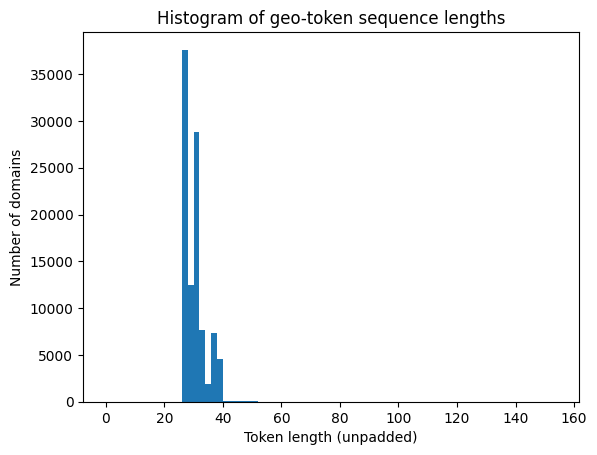

Min: 27,  50th pct: 30.0,  95th pct: 37.0,  Max: 153


In [18]:
# --- Histogram of token lengths (no padding, no truncation) -----
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

assert "input_string" in df.columns, "Build df and input_string first."

tok = AutoTokenizer.from_pretrained("bert-base-uncased")

enc_no_pad = tok(
    df["input_string"].tolist(),
    padding=False,          # keep original lengths
    truncation=False,       # no cutting
)                           # <-- no return_tensors parameter!

seq_lens = [len(ids) for ids in enc_no_pad["input_ids"]]

plt.figure()
plt.hist(seq_lens, bins=range(0, max(seq_lens) + 2, 2))  # width = 2 tokens
plt.xlabel("Token length (unpadded)")
plt.ylabel("Number of domains")
plt.title("Histogram of geo-token sequence lengths")
plt.show()

print(f"Min: {min(seq_lens)},  50th pct: {pd.Series(seq_lens).median()},  "
      f"95th pct: {pd.Series(seq_lens).quantile(0.95)},  Max: {max(seq_lens)}")


In [2]:

# ------------------------------------------------------------------
#  Helpers you already have
# ------------------------------------------------------------------
def geo_tokens_from_ip_data(ip_data):
    if not ip_data:
        return ["ip_count: 0", "countries: NA", "regions: NA",
                "cities: NA", "timezones: NA"]

    ip_count = len(ip_data)
    countries, regions, cities, timezones = set(), set(), set(), set()

    for rec in ip_data:
        if not isinstance(rec, dict):
            continue
        geo = rec.get("geo") or {}
        countries.add(geo.get("country") or geo.get("country_code") or "NA")
        regions.add(geo.get("region") or "NA")
        cities.add(geo.get("city") or "NA")
        timezones.add(geo.get("timezone") or "NA")

    def uniq(vals):
        vals.discard("NA")
        return ", ".join(sorted(vals)) if vals else "NA"

    return [
        f"ip_count: {ip_count}",
        f"countries: {uniq(countries)}",
        f"regions: {uniq(regions)}",
        f"cities: {uniq(cities)}",
        f"timezones: {uniq(timezones)}",
    ]


def prepare_geo_input_string(row):
    CLS, SEP = "[CLS]", "[SEP]"
    domain = (row.get("domain_name") or "NA").lower().lstrip("www.")
    tokens = [f"domain: {domain}"] + geo_tokens_from_ip_data(row.get("ip_data"))
    return f"{CLS} " + f" {SEP} ".join(tokens) + f" {SEP}"


def stream_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield json.loads(line)


def build_dataset(json_path: str | Path, label: int) -> pd.DataFrame:
    """Load a JSON-Lines file and return a DF with domain_name, input_string, label."""
    path = Path(json_path)
    df = pd.DataFrame(stream_json(path))
    df["input_string"] = df.apply(prepare_geo_input_string, axis=1)
    df["label"] = label
    return df[["input_string", "label"]]   # keep only the two required cols

In [3]:
# ------------------------------------------------------------------
#  Build benign and malware sets
# ------------------------------------------------------------------
# --- 1)  stream the massive JSON-lines export ------------------
# Construct the path to the JSON file relative to this script's location.
script_path = Path.cwd()
# Go up 3 levels to the project root (from transformers/data -> transformers -> project_root)
project_root = script_path.parent.parent
# malware_file_path = project_root / "datasets" / "malware" / "malware_strict_ip_2024.json"
malware_file_path = project_root / "datasets" / "phishing" / "phishing_strict_ip_2024.json"
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_ip_2024.json"
df_malware = build_dataset(malware_file_path, label=1)
df_benign  = build_dataset(benign_file_path,  label=0)

In [4]:
# ------------------------------------------------------------------
#  Merge, balance, shuffle, save
# ------------------------------------------------------------------
combined = pd.concat([df_malware, df_benign], ignore_index=True)

# ----- down-sample the larger class so both have the same count -----
minority_size = min(len(df_malware), len(df_benign))

df_malware_bal = df_malware.sample(n=minority_size, random_state=42)
df_benign_bal  = df_benign.sample(n=minority_size,  random_state=42)

balanced = pd.concat([df_malware_bal, df_benign_bal], ignore_index=True)
balanced = balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# out_path = project_root / "datasets" / "malware" / "ip_malware_preprocessed.csv"
out_path = project_root / "datasets" / "phishing" / "ip_phishing_preprocessed.csv"
balanced.to_csv(out_path, index=False)
print(f"✅ Wrote {out_path.resolve()} with {balanced.shape[0]:,} rows "
      f"({minority_size:,} benign + {minority_size:,} malware)")


✅ Wrote /home/fetagpu/Work/01-transofmers/datasets/phishing/ip_phishing_preprocessed.csv with 328,850 rows (164,425 benign + 164,425 malware)
